In [2]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import data as dt


# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Sigmoid for Loss Functions

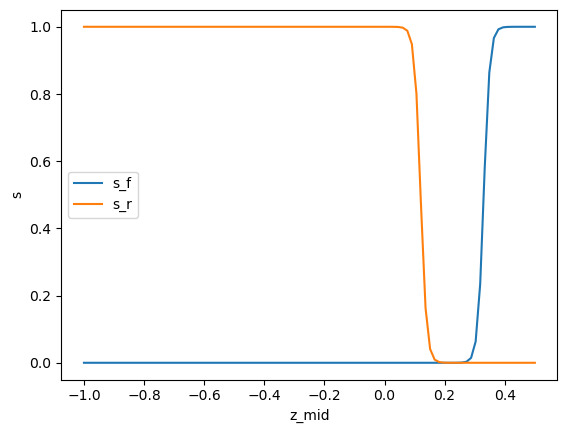

In [5]:
eps, k = 0.22, 100.0
ball_radius = 0.11
z_mid = np.linspace(-1, 0.5, 100)
z_mid = torch.tensor(z_mid, dtype=torch.float32)
s_f = torch.sigmoid(k * (z_mid - ball_radius - eps))
s_r = 1 - torch.sigmoid(k * (z_mid - ball_radius - 0.01))
# Plot s_f
plt.plot(z_mid, s_f, label='s_f')
plt.plot(z_mid, s_r, label='s_r')
plt.xlabel('z_mid')
plt.ylabel('s')
plt.legend()


In [3]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
labels = ['x_cam', 'y_cam', 'R_cam']
trainset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='train', labels=labels)
testset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='test', labels=labels)
validationset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='val', labels=labels)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0, collate_fn=trainset.collate_fn)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=0, collate_fn=testset.collate_fn)
valid_loader = DataLoader(validationset, batch_size=4, shuffle=False, num_workers=0, collate_fn=validationset.collate_fn)


Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='val' size: 23


In [942]:
video, label, _ = trainset.__getitem__(4)
gen = dt.image_gen_for_video(video, label)

Trajectory: 8
Frames shape: torch.Size([1161, 2, 720, 1280])
Max value in frames: 255.0
Video dataset_python_sim\avi_videos_0.5ms\tr8.avi has 1161 frames
Frames video: 1221


In [104]:
video.shape

torch.Size([50, 2, 51, 85])

In [285]:
video.shape

torch.Size([1258, 2, 720, 1280])

In [636]:
cap = cv2.VideoCapture('dataset_python_sim/avi_videos_5ms/tr0.avi')
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    time.sleep(0.001)  # sleep 1ms
    frames.append(frame)
    # process frame
cap.release()

In [637]:
frames = torch.tensor(np.array(frames), dtype=torch.float32)
frames = frames[:, :, :, [0, 2]].transpose(1, 3).transpose(2, 3)

In [638]:
gen = dt.image_gen_for_video(frames, label)

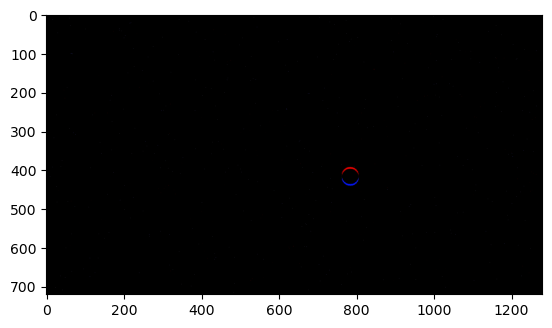

In [612]:
frame = frames[6]
plt.imshow(frame)

720 1280
max tensor(227.)
min tensor(0.)


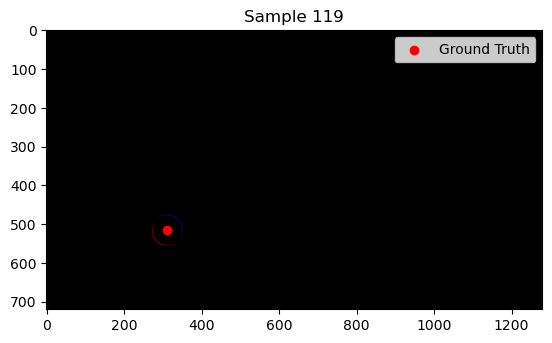

In [1062]:
dt.show_next_img(gen)

In [5]:
def images_from_video(video_path, start_frame=0, end_frame=None):
    """
    Extract images from a video file.
    """
    cap = cv2.VideoCapture(video_path)
    images = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count >= start_frame:
            images.append(frame)
        if end_frame is not None and frame_count >= end_frame:
            break
        frame_count += 1

    cap.release()
    return images

images = images_from_video('dataset_python_sim/videos_1ms/tr0.mp4', start_frame=0)

In [6]:
print(f"Number of images extracted: {len(images)}")

Number of images extracted: 879


# Resampling Trajectories
Here I make the labels fit the fps of the trajectory

In [47]:
from scipy.interpolate import interp1d  # or UnivariateSpline

def resample_timeseries_df(
    df: pd.DataFrame,
    orig_fps: float,
    target_fps: float,
    method: str = 'cubic'  # 'linear', 'quadratic', 'cubic', etc.
) -> pd.DataFrame:
    """
    Resample a DataFrame of equally-spaced samples from orig_fps to target_fps
    by interpolation. Works when target_fps > orig_fps (upsampling)
    or target_fps < orig_fps (downsampling).

    Args:
        df         : DataFrame with shape (N, …).
        orig_fps   : original sampling rate (frames per unit time).
        target_fps : desired sampling rate.
        method     : interpolation kind for scipy.interp1d.

    Returns:
        DataFrame of length M = floor((N-1)*(target_fps/orig_fps)) + 1,
        with the same columns as `df`, smoothly interpolated.
    """
    n_orig = len(df)
    if n_orig < 2:
        return df.copy()  # nothing to resample if <2 points

    # original “time” axis in arbitrary units [0, N-1]
    orig_idx = np.arange(n_orig)

    # compute how many samples we need at target_fps
    duration = (n_orig - 1) / orig_fps
    n_target = int(np.floor(duration * target_fps)) + 1

    # new sampling instants in the same 0…N-1 range
    new_idx = np.linspace(0, n_orig - 1, n_target)

    # build interpolator and evaluate
    df_res = pd.DataFrame(index=new_idx)
    for col in df.columns:
        y = df[col].values
        f = interp1d(orig_idx, y, kind=method, axis=0, fill_value="extrapolate")
        df_res[col] = f(new_idx)

    # reset to simple integer index if you prefer
    return df_res.reset_index(drop=True)

# example usage
df = pd.read_csv(csv_file)
trajectories = df['tr'].unique()
trajectory = trajectories[0]  # Select the first trajectory for demonstration
ms_array = [10, 5, 2, 1, 0.5]
for ms in ms_array:
    print('-' * 20)
    print(f"Resampling to {ms} ms")
    print('-' * 20)
    target_fps = 1000 / ms
    orig_fps = 200
    if target_fps == orig_fps:
        continue
    # Empty DataFrame to store the resampled data with the same columns as df
    ms_df = pd.DataFrame(columns=df.columns)
    for trajectory in trajectories:
        print(f"Processing trajectory {trajectory}")
        df_tr = df[df['tr'] == trajectory]
        df_filtered = df_tr.drop(columns=['tr', 'frame'], inplace=False)
        up = resample_timeseries_df(
            df_filtered,
            orig_fps=orig_fps,
            target_fps=target_fps,
            method='cubic'
        )
        up['frame'] = np.arange(len(up))
        up['tr'] = trajectory
        # Append the resampled data to the ms_df DataFrame
        ms_df = pd.concat([ms_df, up], ignore_index=True)
    ms_df.to_csv(f'dataset_python_sim/positions_{ms}ms.csv', index=False)

--------------------
Resampling to 10 ms
--------------------
Processing trajectory 0
Processing trajectory 1
Processing trajectory 2
Processing trajectory 4
Processing trajectory 5
Processing trajectory 6
Processing trajectory 8
Processing trajectory 10
Processing trajectory 11
Processing trajectory 13
Processing trajectory 14
Processing trajectory 15
Processing trajectory 19
Processing trajectory 26
Processing trajectory 27
Processing trajectory 29
Processing trajectory 33
Processing trajectory 34
Processing trajectory 35
Processing trajectory 36
Processing trajectory 37
Processing trajectory 39
Processing trajectory 41
Processing trajectory 50
Processing trajectory 51
Processing trajectory 52
Processing trajectory 53
Processing trajectory 54
Processing trajectory 60
Processing trajectory 61
Processing trajectory 63
Processing trajectory 64
Processing trajectory 67
Processing trajectory 68
Processing trajectory 69
Processing trajectory 76
Processing trajectory 77
Processing trajector

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15064\3846025244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ms_df = pd.concat([ms_df, up], ignore_index=True)


Processing trajectory 102
Processing trajectory 104
Processing trajectory 105
Processing trajectory 106
Processing trajectory 108
Processing trajectory 109
Processing trajectory 110
Processing trajectory 112
Processing trajectory 116
Processing trajectory 117
Processing trajectory 118
Processing trajectory 119
Processing trajectory 120
Processing trajectory 121
Processing trajectory 122
Processing trajectory 124
Processing trajectory 125
Processing trajectory 126
Processing trajectory 127
Processing trajectory 211
Processing trajectory 214
Processing trajectory 215
Processing trajectory 216
Processing trajectory 218
Processing trajectory 220
Processing trajectory 222
Processing trajectory 223
Processing trajectory 225
Processing trajectory 227
Processing trajectory 233
Processing trajectory 234
Processing trajectory 236
Processing trajectory 237
Processing trajectory 239
Processing trajectory 255
Processing trajectory 261
Processing trajectory 262
Processing trajectory 263
Processing t

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15064\3846025244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ms_df = pd.concat([ms_df, up], ignore_index=True)


Processing trajectory 91
Processing trajectory 92
Processing trajectory 93
Processing trajectory 95
Processing trajectory 98
Processing trajectory 99
Processing trajectory 100
Processing trajectory 102
Processing trajectory 104
Processing trajectory 105
Processing trajectory 106
Processing trajectory 108
Processing trajectory 109
Processing trajectory 110
Processing trajectory 112
Processing trajectory 116
Processing trajectory 117
Processing trajectory 118
Processing trajectory 119
Processing trajectory 120
Processing trajectory 121
Processing trajectory 122
Processing trajectory 124
Processing trajectory 125
Processing trajectory 126
Processing trajectory 127
Processing trajectory 211
Processing trajectory 214
Processing trajectory 215
Processing trajectory 216
Processing trajectory 218
Processing trajectory 220
Processing trajectory 222
Processing trajectory 223
Processing trajectory 225
Processing trajectory 227
Processing trajectory 233
Processing trajectory 234
Processing traject

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15064\3846025244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ms_df = pd.concat([ms_df, up], ignore_index=True)


Processing trajectory 53
Processing trajectory 54
Processing trajectory 60
Processing trajectory 61
Processing trajectory 63
Processing trajectory 64
Processing trajectory 67
Processing trajectory 68
Processing trajectory 69
Processing trajectory 76
Processing trajectory 77
Processing trajectory 78
Processing trajectory 79
Processing trajectory 80
Processing trajectory 82
Processing trajectory 83
Processing trajectory 88
Processing trajectory 90
Processing trajectory 91
Processing trajectory 92
Processing trajectory 93
Processing trajectory 95
Processing trajectory 98
Processing trajectory 99
Processing trajectory 100
Processing trajectory 102
Processing trajectory 104
Processing trajectory 105
Processing trajectory 106
Processing trajectory 108
Processing trajectory 109
Processing trajectory 110
Processing trajectory 112
Processing trajectory 116
Processing trajectory 117
Processing trajectory 118
Processing trajectory 119
Processing trajectory 120
Processing trajectory 121
Processing

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_15064\3846025244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ms_df = pd.concat([ms_df, up], ignore_index=True)


Processing trajectory 51
Processing trajectory 52
Processing trajectory 53
Processing trajectory 54
Processing trajectory 60
Processing trajectory 61
Processing trajectory 63
Processing trajectory 64
Processing trajectory 67
Processing trajectory 68
Processing trajectory 69
Processing trajectory 76
Processing trajectory 77
Processing trajectory 78
Processing trajectory 79
Processing trajectory 80
Processing trajectory 82
Processing trajectory 83
Processing trajectory 88
Processing trajectory 90
Processing trajectory 91
Processing trajectory 92
Processing trajectory 93
Processing trajectory 95
Processing trajectory 98
Processing trajectory 99
Processing trajectory 100
Processing trajectory 102
Processing trajectory 104
Processing trajectory 105
Processing trajectory 106
Processing trajectory 108
Processing trajectory 109
Processing trajectory 110
Processing trajectory 112
Processing trajectory 116
Processing trajectory 117
Processing trajectory 118
Processing trajectory 119
Processing t

In [35]:
target_fps = 87
orig_fps = 200
if target_fps == orig_fps:
    up = df_filtered
up = resample_timeseries_df(
    df_filtered,
    orig_fps=orig_fps,
    target_fps=target_fps,
    method='cubic'
)
up['frame'] = np.arange(len(up))
up['tr'] = trajectory
up

,x,y,z,R_cam,x_cam,y_cam,frame,tr
0,7.777778,8.444444,0.110000,21.000000,787.000000,447.000000,0,0
1,7.764982,8.348889,0.167391,22.089439,786.718698,436.478821,1,0
2,7.752186,8.253334,0.223468,22.005183,786.129938,426.031719,2,0
3,7.739390,8.157778,0.278231,22.000853,784.989152,415.330619,3,0
4,7.726594,8.062223,0.331680,21.949945,784.805624,404.874157,4,0
...,...,...,...,...,...,...,...,...
77,6.792497,1.086673,0.684804,192.072210,362.916164,123.626607,77,0
78,6.779701,0.991118,0.641030,213.782981,308.077548,182.115676,78,0
79,6.766905,0.895563,0.595941,241.164101,240.458000,258.329845,79,0
80,6.754109,0.800007,0.549539,276.447675,151.778830,360.800720,80,0


In [11]:
df_filtered

,x,y,z,R_cam,x_cam,y_cam
0,7.777778,8.444444,0.110000,21,787.0,447.0
1,7.772235,8.403054,0.135020,21,787.0,442.0
2,7.766693,8.361664,0.159794,22,787.0,438.0
3,7.761150,8.320273,0.184322,22,786.0,433.0
4,7.755607,8.278883,0.208603,22,786.0,429.0
...,...,...,...,...,...,...
183,6.763484,0.870013,0.583663,250,219.0,283.0
184,6.757941,0.828623,0.563572,265,181.0,327.0
185,6.752399,0.787232,0.543236,282,138.0,377.0
186,6.746856,0.745842,0.522652,302,90.0,435.0


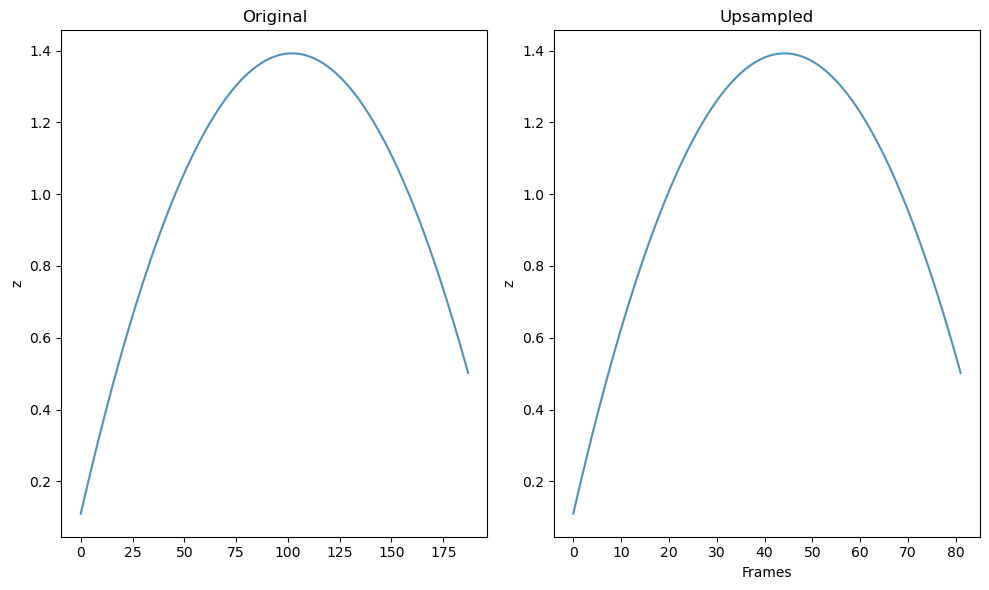

In [40]:

column = 'z'

# Plot original on its own figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].plot(df_tr['frame'], df_tr[column], label='Original', alpha=0.8)
axes[0].set_ylabel(column)
axes[0].set_title('Original')

axes[1].plot(up['frame'], up[column], label='Upsampled', alpha=0.8)
axes[1].set_xlabel('Frames')
axes[1].set_ylabel(column)
axes[1].set_title('Upsampled')

plt.tight_layout()
plt.show()


In [44]:
csv_file = 'dataset_python_sim/trajectories.csv'
df = pd.read_csv(csv_file)
# Get rid of the values for which tr == 284
df = df[df['tr'] != 284]
df.to_csv(csv_file, index=False)

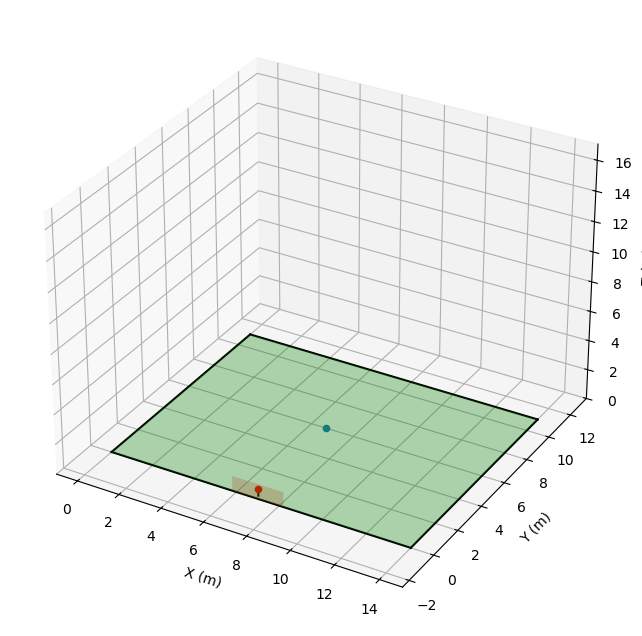

In [37]:
from simulator import Camera, Field

W = 14.0      # field width (m)
L = 11.0       # field length (m)

field = Field(W, L, 2.4, 1)


# CameraLeft
cam_x = -0.05994 + 7
cam_y = -11 + 0.12 + 0.025 + 11
cam_z = 0.55

camera_pos = np.array([cam_x, cam_y, cam_z])          # Camera position in world space

fps = 200

# ---------------------
# Define camera parameters for the pinhole model
# ---------------------      
# Where the camera is looking (center of field)
camera_target = np.array([field.center[0], field.center[1], camera_pos[2]])        # Where the camera is looking (center of field) It would be good to transform this into an angle and assume verticality
orientation = Camera.get_orientation(camera_pos, camera_target)
img_width, img_height = 1280, 720               # Image resolution (in pixels)
focal_length = 0.008                             # Focal length in meters

camera = Camera(camera_pos, orientation, focal_length, img_width, img_height, fps = fps)

fig, ax = field.plot()
camera.plot(ax)
ax.scatter(*camera_target)

In [40]:
csv_file = 'dataset_python_sim/positions_10ms.csv'
df = pd.read_csv(csv_file)
# grab raw arrays (or tensors) out of the frame
x_cam_arr = df['x_cam'].values   # shape (N,)
y_cam_arr = df['y_cam'].values
R_cam_arr = df['R_cam'].values

# call your function once on the whole batch
world_pts = camera.project_ball_camera_to_world_old(
    (x_cam_arr, y_cam_arr, R_cam_arr),
    camera_coords_flag=False
)  # returns shape (N, 3)

# assign back
df[['x_calc','y_calc','z_calc']] = world_pts
df

,tr,frame,x,y,z,R_cam,x_cam,y_cam,x_calc,y_calc,z_calc
0,0,0,7.777778,8.444444,0.110000,21.000000,787.000000,273.000000,7.806518,8.758221,0.094286
1,0,1,7.766633,8.361219,0.160059,22.005714,786.992720,282.049997,7.766883,8.364576,0.160351
2,0,2,7.755488,8.277993,0.209122,22.000810,786.007256,291.092516,7.762140,8.366463,0.205475
3,0,3,7.744343,8.194767,0.257188,22.000196,784.981447,301.136585,7.757035,8.366750,0.255686
4,0,4,7.733199,8.111542,0.304258,22.002102,785.005886,310.190191,7.757086,8.366037,0.300975
...,...,...,...,...,...,...,...,...,...,...,...
21526,337,56,8.077199,3.312750,1.049980,56.000000,1210.000000,619.000000,8.095823,3.365658,1.058750
21527,337,57,8.074970,3.229049,1.038625,58.000000,1224.000000,620.000000,8.082519,3.254304,1.043103
21528,337,58,8.072741,3.145349,1.026283,60.000000,1240.000000,621.000000,8.073768,3.150332,1.028500
21529,337,59,8.070512,3.061648,1.012953,61.000000,1256.000000,621.000000,8.084034,3.100741,1.020656


In [48]:
csv_file = 'dataset_python_sim/positions_10ms.csv'
df = pd.read_csv(csv_file)
df[['x_calc', 'y_calc', 'z_calc']] = df[['x_cam', 'y_cam', 'R_cam']].apply(CAMERA.project_ball_camera_to_world, axis=1, result_type='expand')

df

,tr,frame,x,y,z,R_cam,x_cam,y_cam,in_fov,x_calc,y_calc,z_calc
0,0,0,7.777778,8.444444,0.110000,21.000000,787.000000,273.000000,1.0,7.806518,8.758221,0.094286
1,0,1,7.766633,8.361219,0.160059,22.005714,786.992720,282.049997,1.0,7.766883,8.364576,0.160351
2,0,2,7.755488,8.277993,0.209122,22.000810,786.007256,291.092516,1.0,7.762140,8.366463,0.205475
3,0,3,7.744343,8.194767,0.257188,22.000196,784.981447,301.136585,1.0,7.757035,8.366750,0.255686
4,0,4,7.733199,8.111542,0.304258,22.002102,785.005886,310.190191,1.0,7.757086,8.366037,0.300975
...,...,...,...,...,...,...,...,...,...,...,...,...
21526,337,56,8.077199,3.312750,1.049980,56.000000,1210.000000,619.000000,1.0,8.095823,3.365658,1.058750
21527,337,57,8.074970,3.229049,1.038625,58.000000,1224.000000,620.000000,1.0,8.082519,3.254304,1.043103
21528,337,58,8.072741,3.145349,1.026283,60.000000,1240.000000,621.000000,1.0,8.073768,3.150332,1.028500
21529,337,59,8.070512,3.061648,1.012953,61.000000,1256.000000,621.000000,1.0,8.084034,3.100741,1.020656


In [51]:
filtered_df = df[df['z_calc'] <= 0]
filtered_df

,tr,frame,x,y,z,R_cam,x_cam,y_cam,in_fov,x_calc,y_calc,z_calc


In [24]:
df[['x_calc', 'y_calc', 'z_calc', 'x', 'y', 'z']] = df[['x_calc', 'y_calc', 'z_calc', 'x', 'y', 'z']].round(1)
df.head(20)

,tr,frame,x,y,z,R_cam,x_cam,y_cam,x_calc,y_calc,z_calc,vx_calc,vy_calc,vz_calc,vx,vy,vz
0,0,0,7.8,8.4,0.1,21.000000,787.000000,273.000000,7.8,8.8,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,7.8,8.4,0.2,22.005714,786.992720,282.049997,7.8,8.4,0.2,-7.927126,-78.728918,13.213096,-2.228956,-16.645146,10.011882
2,0,2,7.8,8.3,0.2,22.000810,786.007256,291.092516,7.8,8.4,0.2,-0.948507,0.377455,9.024816,-2.228956,-16.645146,9.812550
3,0,3,7.7,8.2,0.3,22.000196,784.981447,301.136585,7.8,8.4,0.3,-1.021144,0.057394,10.042055,-2.228956,-16.645146,9.613219
4,0,4,7.7,8.1,0.3,22.002102,785.005886,310.190191,7.8,8.4,0.3,0.010283,-0.142694,9.057839,-2.228956,-16.645146,9.413887
5,0,5,7.7,8.0,0.4,22.037147,783.966255,319.237697,7.8,8.4,0.3,-1.297671,-2.603105,9.111458,-2.228956,-16.645146,9.214556
6,0,6,7.7,7.9,0.4,22.990248,783.952943,328.284349,7.7,8.0,0.4,-6.733194,-68.055498,10.344015,-2.228956,-16.645146,9.015224
7,0,7,7.7,7.9,0.4,22.999472,783.024942,337.330738,7.7,8.0,0.4,-0.949929,-0.621116,8.665438,-2.228956,-16.645146,8.815892
8,0,8,7.7,7.8,0.5,23.004355,781.949839,346.378251,7.7,8.0,0.5,-1.060877,-0.322345,8.657108,-2.228956,-16.645146,8.616561
9,0,9,7.7,7.7,0.5,23.070961,781.926723,355.447988,7.7,8.0,0.5,-0.464803,-4.539865,8.686326,-2.228956,-16.645146,8.417229


In [15]:
csv_file = 'dataset_python_sim/positions_10ms.csv'
df = pd.read_csv(csv_file)

Flattened feature size: 14080
Epoch 1/50, Loss: 12953.0048, Validation Error: 562.4722 pixels
Epoch 2/50, Loss: 12909.0349, Validation Error: 560.9946 pixels
Epoch 3/50, Loss: 12804.8558, Validation Error: 559.4848 pixels
Epoch 4/50, Loss: 12731.7384, Validation Error: 557.9583 pixels
Epoch 5/50, Loss: 12656.7327, Validation Error: 556.4174 pixels
Epoch 6/50, Loss: 12585.1837, Validation Error: 554.8505 pixels
Epoch 7/50, Loss: 12531.6853, Validation Error: 553.2987 pixels
Epoch 8/50, Loss: 12478.3055, Validation Error: 551.7756 pixels
Epoch 9/50, Loss: 12380.9438, Validation Error: 550.1898 pixels
Epoch 10/50, Loss: 12314.8672, Validation Error: 548.5137 pixels
Epoch 11/50, Loss: 12247.6072, Validation Error: 546.6135 pixels
Epoch 12/50, Loss: 12348.4098, Validation Error: 543.5490 pixels
Epoch 13/50, Loss: 14832.5735, Validation Error: 541.8843 pixels
Epoch 14/50, Loss: 12906.2862, Validation Error: 545.2563 pixels
Epoch 15/50, Loss: 12148.1370, Validation Error: 542.2724 pixels
Epoc

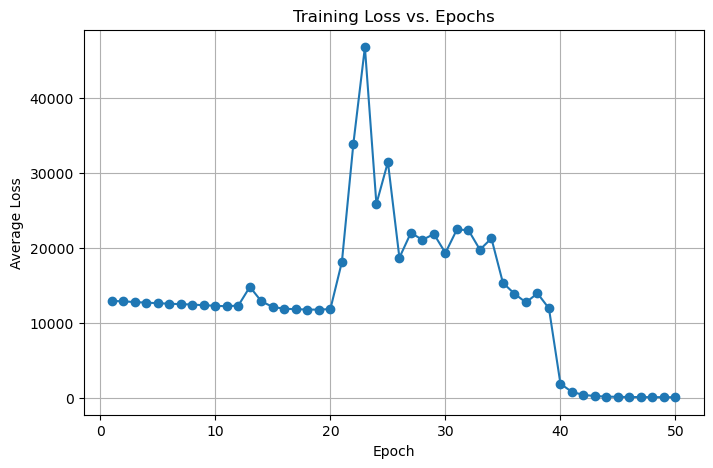

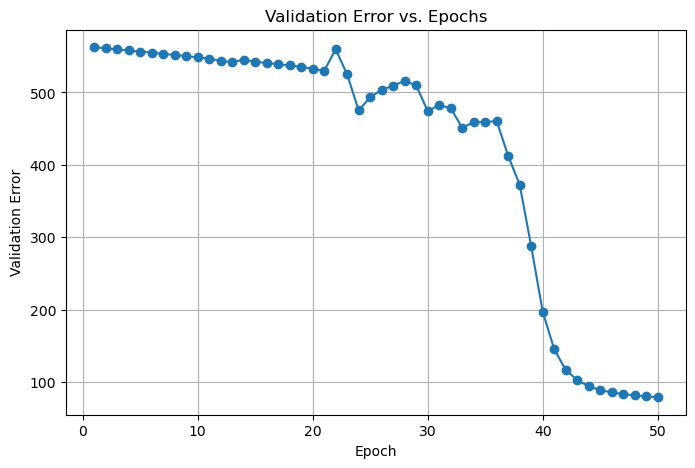

In [4]:
model = network.PISNN(trainset).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = network.pinn_loss
model.start_training(testloader, optimizer, device, loss_function, validationloader=valid_loader, num_steps=12, num_epochs=50) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

Epoch 1/25, Loss: 128.3968, Validation Error: 77.7890 pixels
Epoch 2/25, Loss: 124.9375, Validation Error: 76.8581 pixels
Epoch 3/25, Loss: 121.9307, Validation Error: 75.9195 pixels
Epoch 4/25, Loss: 119.0777, Validation Error: 74.9589 pixels
Epoch 5/25, Loss: 116.1958, Validation Error: 73.9217 pixels
Epoch 6/25, Loss: 113.2629, Validation Error: 72.7854 pixels
Epoch 7/25, Loss: 110.4338, Validation Error: 71.8038 pixels
Epoch 8/25, Loss: 108.4121, Validation Error: 70.3473 pixels
Epoch 9/25, Loss: 105.5143, Validation Error: 69.0680 pixels
Epoch 10/25, Loss: 102.1995, Validation Error: 67.6704 pixels
Epoch 11/25, Loss: 98.3961, Validation Error: 65.0058 pixels
Epoch 12/25, Loss: 88.7808, Validation Error: 58.8162 pixels
Epoch 13/25, Loss: 86.7018, Validation Error: 57.1130 pixels
Epoch 14/25, Loss: 84.6091, Validation Error: 59.8269 pixels
Epoch 15/25, Loss: 83.1098, Validation Error: 59.5591 pixels
Epoch 16/25, Loss: 80.4506, Validation Error: 58.6460 pixels
Epoch 17/25, Loss: 77.1

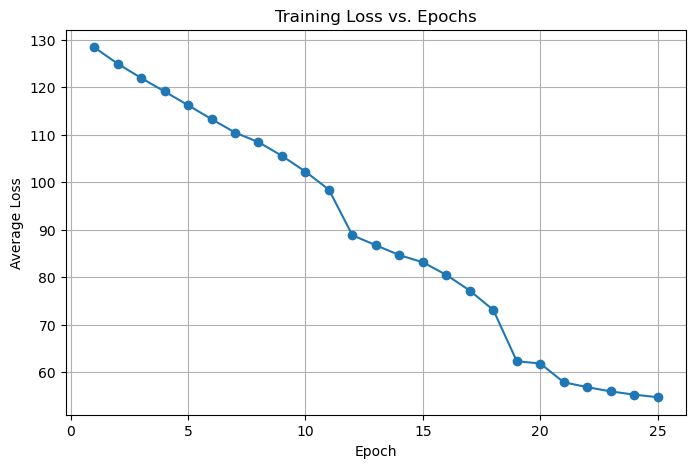

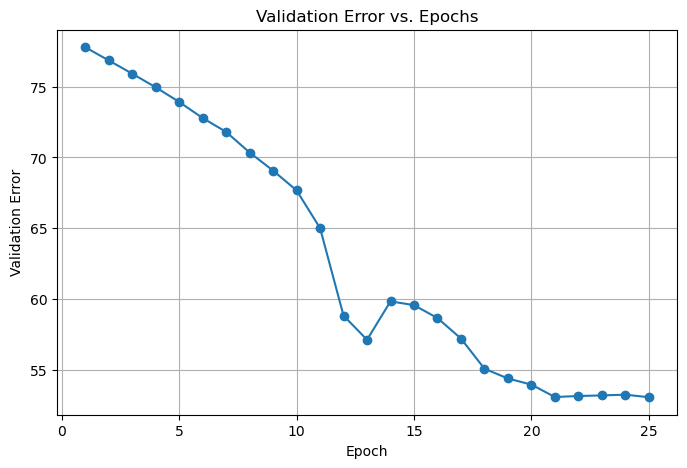

In [5]:
model.start_training(testloader, optimizer, device, loss_function, validationloader=valid_loader, num_steps=12, num_epochs=25) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

In [7]:
model.training_params['num_epochs'] = 75

In [8]:
network.save_model(model)

Model saved at models/PISNN_q8_12ts_75e.pt


In [2]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.10.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            C:/b/abs_2dcy5vu2ph/croot/opencv-suite_1742485375548/work/opencv_contrib/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2025-03-20T16:43:15Z
    Host:                        Windows 10.0.17763 AMD64
    CMake:                       3.31.2
    CMake generator:             Ninja
    CMake build tool:            C:/b/abs_2dcy5vu2ph/croot/opencv-suite_1742485375548/_build_env/Library/bin/ninja.exe
    MSVC:                        1929
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SS

In [7]:
model = network.load_model('models/PISNN_q8_10ts_50e.pt', network.PISNN, trainset, device)

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2017: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Flattened feature size: 14080


In [99]:
video, label, length = testset.__getitem__(0)
preds = dt.get_preds_video_classification(model, video, length, trainset.labels, device, num_steps=12)
gen = dt.image_gen_for_video(video, label, preds)


torch.Size([1, 160, 16])
torch.Size([1, 16])
torch.Size([1, 720, 16])
torch.Size([1, 16])
torch.Size([1, 100, 16])
torch.Size([1, 16])
(3, 16)


In [116]:
dt.show_next_img_w_pred(gen)

StopIteration: 

In [55]:
print([preds[i][0].item() for i in range(len(preds))])

RuntimeError: a Tensor with 59 elements cannot be converted to Scalar

In [56]:
len(preds)

3

In [34]:
network.save_model(model)

Model saved at models/PISNN_q8_10ts_50e.pt


In [29]:
model.evaluate(valid_loader, device, num_steps=10, print_results=True)

Average Error for x_cam: 48.3397 pixels
Average Error for y_cam: 48.3397 pixels
Average Error for R_cam: 48.3397 pixels


array([48.339653, 48.339653, 48.339653], dtype=float32)

In [11]:
model.training_params['loss_function'] = network.regression_loss.__name__
print(model.training_params['loss_function'])

regression_loss


In [11]:
def chunk_size_calculator(b, q, n_steps, A=35):
    """
    Calculate the chunk size for the given parameters.

    Parameters:
        b (int): Batch size
        q (int): Quantization factor
        n_steps (int): Number of steps
        A (int): Constant factor (default is 35). Increasing this value will increase the risk of running out of memory.
    """
    # Calculate the chunk size
    chunk_size = int(A * q ** 2 / b / n_steps)
    return chunk_size

chunk_size_calculator(3, 2, 10)

4

In [15]:
len(testloader.dataset)

24

In [10]:
dummy_array = [3, 4, 5, 6, 7, 8, 9, 10]
dummy_array2 = [1, 2, 3, 4, 5, 6, 7, 8]
for i, (j, k) in enumerate(zip(dummy_array, dummy_array2)):
    print(i, j, k)

0 3 1
1 4 2
2 5 3
3 6 4
4 7 5
5 8 6
6 9 7
7 10 8


In [5]:
chunk_size = 10
T = 110
total_chunks = T // chunk_size + (T % chunk_size > 0)
print(total_chunks)

11


# Data Treatment
## Getting rid of out-of-FOV frames

In [336]:
height = 720
accumulation_times = [10, 5, 2, 1, 0.5]
trajectories_csv = 'dataset_python_sim/trajectories.csv'
for ms in accumulation_times:
    positions_csv = f'dataset_python_sim/positions_{ms}ms.csv'
    new_positions_csv = f'dataset_python_sim/positions_in_fov_{ms}ms.csv'
    traj_df = pd.read_csv(trajectories_csv)
    pos_df = pd.read_csv(positions_csv)
    new_positions_df = pd.DataFrame(columns=pos_df.columns)
    for traj in traj_df['tr'].unique():
        positions_traj = pos_df[pos_df['tr'] == traj]
        last_frame_in_fov = positions_traj[positions_traj['y_cam'] > height]['frame'].min() - 1
        if pd.isna(last_frame_in_fov):
            last_frame_in_fov = positions_traj['frame'].max()
        positions_traj = positions_traj[positions_traj['frame'] <= last_frame_in_fov]
        new_positions_df = pd.concat([new_positions_df, positions_traj], ignore_index=True)
    new_positions_df.to_csv(new_positions_csv, index=False)

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_17160\2491627435.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_positions_df = pd.concat([new_positions_df, positions_traj], ignore_index=True)
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_17160\2491627435.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_positions_df = pd.concat([new_positions_df, positions_traj], ignore_index=True)
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_17160\2491627435.py:16: FutureWarning: 

In [331]:
new_positions_df['tr'].unique()

array([0, 13, 34, 215, 216, 237, 272, 312, 315, 335], dtype=object)

In [89]:
(new_positions_df['y_cam']).max()



720.0

# Get Dataset In-FOV

In [4]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train')
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test')
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val')
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)
# model = network.PISNN(trainset).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_function = network.pinn_loss
# model.start_training(testloader, optimizer, device, loss_function, validationloader=valid_loader, num_steps=12, num_epochs=50)


Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='val' size: 23


In [168]:
video, label, length = trainset.__getitem__(4)
preds = dt.get_preds_video_regression(model, video, length, trainset.labels, device, num_steps=12)
gen = dt.image_gen_for_video(video, label, preds)

torch.Size([1, 1, 58])
torch.Size([1, 1, 58])
torch.Size([1, 1, 58])
torch.Size([1, 1, 58])
torch.Size([1, 1, 58])
torch.Size([1, 1, 58])
(3, 58)


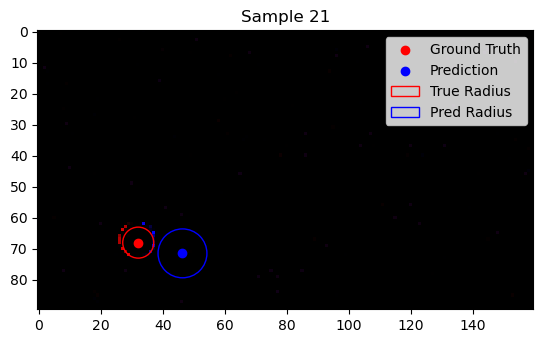

In [190]:
dt.show_next_img_w_pred(gen)

180 320
max tensor(1.)
min tensor(0.)


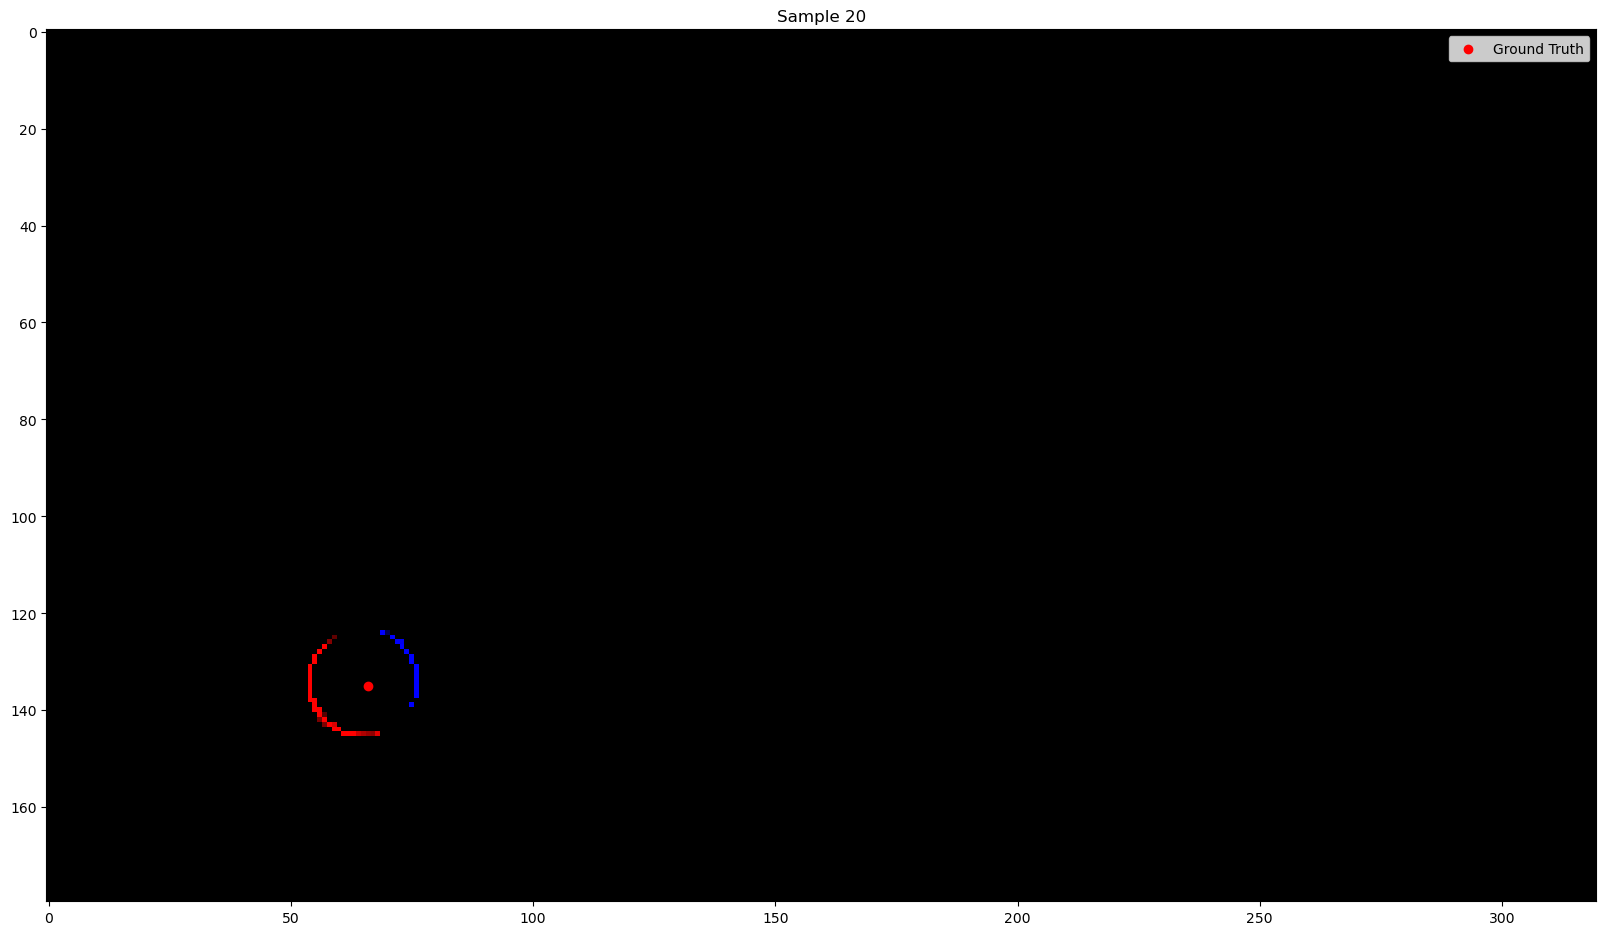

In [165]:
dt.show_next_img(gen)

# Next steps
1. Create the new videos
2. Check the newly created events are right
3. Check whether convergence occurs with this new dataset
4. If it doesnt, check the new approach of training on the dataset of just in-fov frames, then finetuning on full trajectories
5. If it doesnt work, implement visibility head plus KF for when the ball is not in view.

In [73]:
from pathlib import Path
import shutil

# --- EDIT THESE THREE LINES -----------------------------------------------
FOLDER_A = Path(r"dataset_python_sim/events")   # reference folder
FOLDER_B = Path(r"dataset_python_sim/rgb")   # folder to scan & possibly copy from
FOLDER_C = Path(r"dataset_python_sim/rgb2")   # destination for the unique files
# ---------------------------------------------------------------------------

# Create destination if it does not yet exist
FOLDER_C.mkdir(parents=True, exist_ok=True)

# Collect basenames (no extension) for every file in A
names_in_a = {p.stem for p in FOLDER_A.iterdir() if p.is_file()}

# Walk through B and copy the ones whose stem is *not* in A
copied = 0
for src in FOLDER_B.iterdir():
    if not src.is_file():
        continue                        # skip sub-dirs etc.
    if src.stem not in names_in_a:
        shutil.copy2(src, FOLDER_C / src.name)
        copied += 1

print(f"Done. {copied} file(s) copied to {FOLDER_C}")

Done. 35 file(s) copied to dataset_python_sim\rgb2


In [5]:
df = pd.read_csv('dataset_python_sim/positions_10ms.csv')
print(df['x_cam'].max(), df['x_cam'].min())
print(df['y_cam'].max(), df['y_cam'].min())
print(df['R_cam'].max(), df['R_cam'].min())

1279.0 1.0
1854.0 1.0
1058.0 15.984069241163892


In [34]:
model = network.SCNNVideoClassification(trainset_in, weighted_avg=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = network.classification_loss
# model.max_values['y_cam'] = 720
model.start_training(testloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=10, num_epochs=50) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING


Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
All errors 3
Average Error for x_cam: 50.3603 pixels
Average Error for y_cam: 11.0203 pixels
Average Error for R_cam: 1.5859 pixels
Epoch 1/50, Loss: 0.2477, Validation Error: 51.5764 pixels
All errors 3
Average Error for x_cam: 50.3783 pixels
Average Error for y_cam: 11.0152 pixels
Average Error for R_cam: 1.5852 pixels
Epoch 2/50, Loss: 0.2474, Validation Error: 51.5928 pixels
All errors 3
Average Error for x_cam: 50.4676 pixels
Average Error for y_cam: 11.0193 pixels
Average Error for R_cam: 1.5831 pixels
Epoch 3/50, Loss: 0.2471, Validation Error: 51.6808 pixels
All errors 3
Average Error for x_cam: 48.3838 pixels
Average Error for y_cam: 10.9990 pixels
Average Error for R_cam: 1.5793 pixels
Epoch 4/50, Loss: 0.2468, Validation Error: 49.6434 pixels
All errors 3
Average Error for x_cam: 48.1586 pixels
Average Error for y_cam: 10.8748 pixels
Average Error for R_cam: 1.5897 pixe

KeyboardInterrupt: 

In [ ]:

dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 4
batch_size = 4
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train')
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test')
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val')
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

model = network.SCNNVideoClassification(trainset_in, weighted_avg=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = network.classification_loss
model.start_training(testloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=1, num_epochs=50, save = [30,50], chunk_size = 10) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING



In [10]:
network.save_model(model)

Model saved at models/VideoRegression_q8_10ts_31e.pt


In [33]:
# loss_function = network.pinn_loss
# model.weighted_avg = True
model.start_training(testloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=1, num_epochs=50) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

All errors 3
Average Error for x_cam: 13.9879 pixels
Average Error for y_cam: 4.2883 pixels
Average Error for R_cam: 1.9290 pixels
Epoch 1/50, Loss: 0.0675, Validation Error: 14.7571 pixels
All errors 3
Average Error for x_cam: 13.5034 pixels
Average Error for y_cam: 4.1700 pixels
Average Error for R_cam: 1.8731 pixels
Epoch 2/50, Loss: 0.0634, Validation Error: 14.2562 pixels
All errors 3
Average Error for x_cam: 14.1666 pixels
Average Error for y_cam: 4.1572 pixels
Average Error for R_cam: 1.8493 pixels
Epoch 3/50, Loss: 0.0612, Validation Error: 14.8793 pixels
All errors 3
Average Error for x_cam: 14.7783 pixels
Average Error for y_cam: 4.2290 pixels
Average Error for R_cam: 1.7945 pixels
Epoch 4/50, Loss: 0.0590, Validation Error: 15.4758 pixels
All errors 3
Average Error for x_cam: 14.8979 pixels
Average Error for y_cam: 4.4986 pixels
Average Error for R_cam: 1.7841 pixels
Epoch 5/50, Loss: 0.0578, Validation Error: 15.6643 pixels
All errors 3
Average Error for x_cam: 13.9393 pixe

KeyboardInterrupt: 

In [17]:
network.load_model('models/VideoTrackerClass_q8_1ts_25e.pt', network.SCNNVideoClassification, trainset, device)
model.evaluate(valid_loader_in, device, num_steps=10, print_results=True)

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1755: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 160
Number of y_cam bins: 90
Number of R_cam bins: 12


RuntimeError: Error(s) in loading state_dict for SCNNVideoClassification:
	size mismatch for fc_layers.y_cam.weight: copying a param with shape torch.Size([720, 14080]) from checkpoint, the shape in current model is torch.Size([90, 14080]).
	size mismatch for fc_layers.y_cam.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([90]).
	size mismatch for fc_layers.R_cam.weight: copying a param with shape torch.Size([100, 14080]) from checkpoint, the shape in current model is torch.Size([12, 14080]).
	size mismatch for fc_layers.R_cam.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([12]).

In [ ]:
loss_function = network.pinn_loss
model.start_training(testloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=1, num_epochs=25) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

In [9]:
network.save_model(model)

Model saved at models/VideoTrackerClass_q8_1ts_25e.pt


Epoch 1/25, Loss: 6.7591, Validation Error: 22.2893 pixels
Epoch 2/25, Loss: 7.3495, Validation Error: 20.7881 pixels
Epoch 3/25, Loss: 6.9183, Validation Error: 21.4116 pixels
Epoch 4/25, Loss: 8.0292, Validation Error: 23.3831 pixels
Epoch 5/25, Loss: 8.1249, Validation Error: 21.7723 pixels
Epoch 6/25, Loss: 8.4291, Validation Error: 23.3793 pixels
Epoch 7/25, Loss: 10.2904, Validation Error: 22.2629 pixels
Epoch 8/25, Loss: 8.3182, Validation Error: 21.8413 pixels
Epoch 9/25, Loss: 8.3089, Validation Error: 21.0626 pixels
Epoch 10/25, Loss: 7.3267, Validation Error: 21.6393 pixels
Epoch 11/25, Loss: 6.7471, Validation Error: 20.0537 pixels
Epoch 12/25, Loss: 6.1031, Validation Error: 20.1785 pixels
Epoch 13/25, Loss: 5.9468, Validation Error: 20.6507 pixels
Epoch 14/25, Loss: 5.7389, Validation Error: 20.2527 pixels
Epoch 15/25, Loss: 5.6078, Validation Error: 20.1552 pixels
Epoch 16/25, Loss: 5.5718, Validation Error: 20.3190 pixels
Epoch 17/25, Loss: 5.5053, Validation Error: 21.

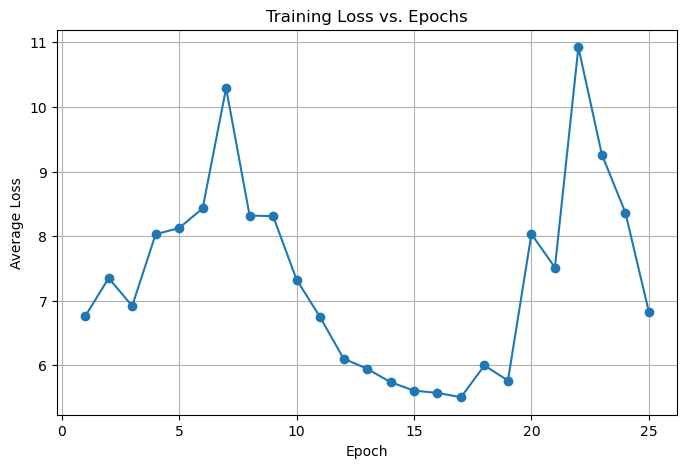

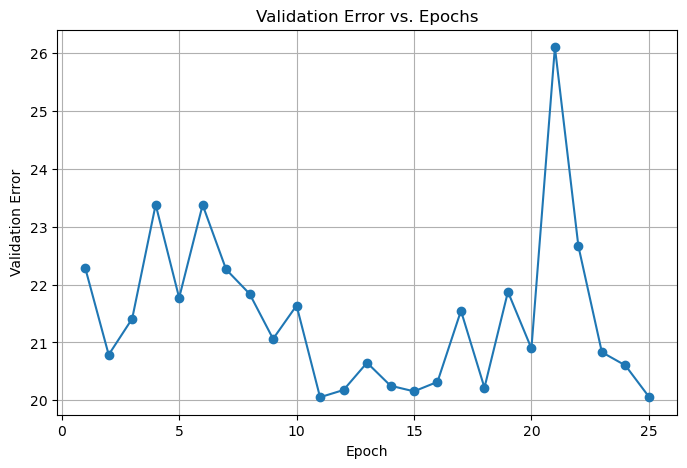

In [17]:
model.start_training(testloader, optimizer, device, loss_function=loss_function, validationloader=valid_loader, num_steps=10, num_epochs=25) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

In [74]:
model = network.load_model('models/VideoTrackerClass_q8_1ts_25e.pt', network.SCNN_Video_Tracker_Class, trainset, device)

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1738: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = model_class(trainset, w

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 160
Number of y_cam bins: 720
Number of R_cam bins: 100


In [36]:
video, label, length = testset_in.__getitem__(1)
preds = dt.get_preds_video_classification(model, video, length, trainset.labels, device, num_steps=10)
gen = dt.image_gen_for_video(video, label, preds)

AttributeError: 'float' object has no attribute 'get_preds_video_classification'

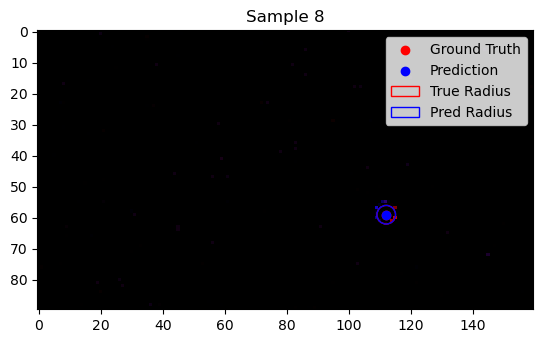

In [ ]:
dt.show_next_img_w_pred(gen)

In [126]:
video, label, length = testset_in.__getitem__(0)
gen = dt.image_gen_for_video(video, label)

In [143]:
dt.show_next_img(gen)

StopIteration: 

In [ ]:
model.evaluate(valid_loader_in, device, num_steps=1, print_results=True, weighted_avg=False)

Average Error for x_cam: 3.0000 pixels
Average Error for y_cam: 4.0000 pixels
Average Error for R_cam: 1.0000 pixels


array([3., 4., 1.])

In [89]:
network.plot_timestep_curve(model, valid_loader_in, device, interval=[1, 10, 1])

KeyboardInterrupt: 

In [ ]:
network.evaluate_video_regression_tracker

# Kalman Filter

## Adding in_FOV column

In [28]:
height = 720
accumulation_times = [10, 5, 2, 1, 0.5]
trajectories_csv = 'dataset_python_sim/trajectories.csv'
for ms in accumulation_times:
    positions_csv = f'dataset_python_sim/positions_{ms}ms.csv'
    traj_df = pd.read_csv(trajectories_csv)
    pos_df = pd.read_csv(positions_csv)
    new_positions_df = pd.DataFrame(columns=pos_df.columns)
    for traj in traj_df['tr'].unique():
        positions_traj = pos_df[pos_df['tr'] == traj]
        frames_out_fov = positions_traj[positions_traj['y_cam'] > height]['frame']
        pos_df.loc[(pos_df['tr'] == traj) & (pos_df['frame'].isin(frames_out_fov)), 'in_fov'] = 0
        pos_df.loc[(pos_df['tr'] == traj) & (~pos_df['frame'].isin(frames_out_fov)), 'in_fov'] = 1
    pos_df.to_csv(positions_csv, index=False)

In [26]:
pos_df[pos_df['in_fov'] == 0]

,tr,frame,x,y,z,R_cam,x_cam,y_cam,in_fov
54,0,54,7.175960,3.950255,1.386991,46.980562,723.535565,721.740096,0.0
55,0,55,7.164815,3.867029,1.383231,47.980732,720.427001,727.774064,0.0
56,0,56,7.153670,3.783804,1.378474,49.014875,717.275810,733.806432,0.0
57,0,57,7.142525,3.700578,1.372720,50.752220,714.717835,739.838563,0.0
58,0,58,7.131381,3.617352,1.365970,51.650187,711.731955,745.868936,0.0
...,...,...,...,...,...,...,...,...,...
21367,335,68,7.342967,3.292800,1.243785,56.653592,831.461061,722.045039,0.0
21368,335,69,7.340732,3.208871,1.226081,58.695156,836.240931,722.001033,0.0
21369,335,70,7.338497,3.124942,1.207381,59.966094,841.257074,721.971596,0.0
21370,335,71,7.336262,3.041012,1.187685,61.761872,846.281342,721.190727,0.0


In [4]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
labels = ['x_cam', 'y_cam', 'R_cam', 'in_fov']
trainset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='train', labels=labels)
print(labels)
testset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='test', labels=labels)
validationset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='val', labels=labels)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0, collate_fn=trainset.collate_fn)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=0, collate_fn=testset.collate_fn)
valid_loader = DataLoader(validationset, batch_size=4, shuffle=False, num_workers=0, collate_fn=validationset.collate_fn)

Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109
['x_cam', 'y_cam', 'R_cam', 'in_fov']
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='val' size: 23


In [1]:
model = network.SCNNVideoClassification(trainset_in, weighted_avg=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = network.classification_loss_w_confidence
model.start_training(testloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=10, num_epochs=25) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

NameError: name 'network' is not defined

Average Error for x_cam: 2.0000 pixels
Average Error for y_cam: 2.0000 pixels
Average Error for R_cam: 2.0000 pixels
Average Error for in_fov: 8.0000 pixels
Epoch 1/10, Loss: 0.1745, Validation Error: 8.7178 pixels
Average Error for x_cam: 2.0000 pixels
Average Error for y_cam: 2.0000 pixels
Average Error for R_cam: 2.0000 pixels
Average Error for in_fov: 2.0000 pixels
Epoch 2/10, Loss: 0.1693, Validation Error: 4.0000 pixels
Average Error for x_cam: 2.0000 pixels
Average Error for y_cam: 2.0000 pixels
Average Error for R_cam: 2.0000 pixels
Average Error for in_fov: 2.0000 pixels
Epoch 3/10, Loss: 0.1614, Validation Error: 4.0000 pixels
Average Error for x_cam: 2.0000 pixels
Average Error for y_cam: 2.0000 pixels
Average Error for R_cam: 2.0000 pixels
Average Error for in_fov: 2.0000 pixels
Epoch 4/10, Loss: 0.1454, Validation Error: 4.0000 pixels
Average Error for x_cam: 2.0000 pixels
Average Error for y_cam: 2.0000 pixels
Average Error for R_cam: 2.0000 pixels
Average Error for in_fo

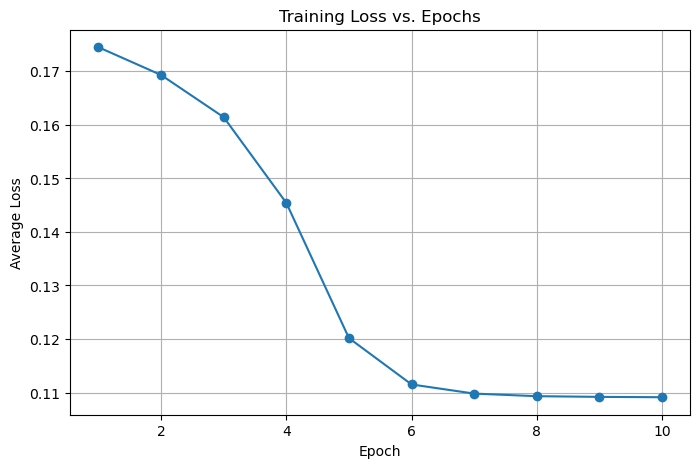

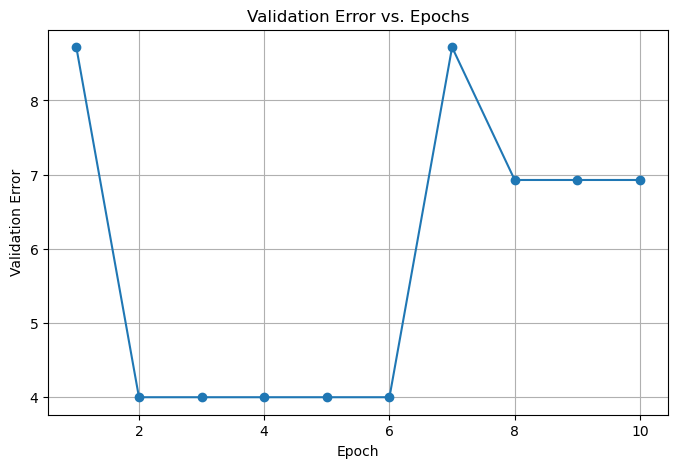

In [194]:
model.start_training(testloader, optimizer, device, loss_function=loss_function, validationloader=valid_loader, num_steps=10, num_epochs=10) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING

In [10]:
video, label, length = validationset.__getitem__(1)
preds = dt.get_preds_video_classification(model, video, length, trainset.labels, device, num_steps=1)
gen = dt.image_gen_for_video(video, label, preds)

torch.Size([1, 161, 327])
torch.Size([1, 327])
torch.Size([1, 91, 327])
torch.Size([1, 327])
torch.Size([1, 101, 327])
torch.Size([1, 327])
torch.Size([1, 1, 327])
torch.Size([1, 327])
(4, 327)


In [242]:
model.evaluate(valid_loader, device, num_steps=1, print_results=True)

All errors 4
Average Error for x_cam: 27.5734 pixels
Average Error for y_cam: 12.5734 pixels
Average Error for R_cam: 1.2735 pixels
Average Error for in_fov: 0.9084 pixels


array([27.57344806, 12.57344806,  1.27350953,  0.90842041])

In [11]:
preds

array([[53, 53, 53, ..., 53, 53, 53],
       [29, 29, 29, ..., 29, 29, 29],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 0,  0,  0, ...,  0,  0,  0]])

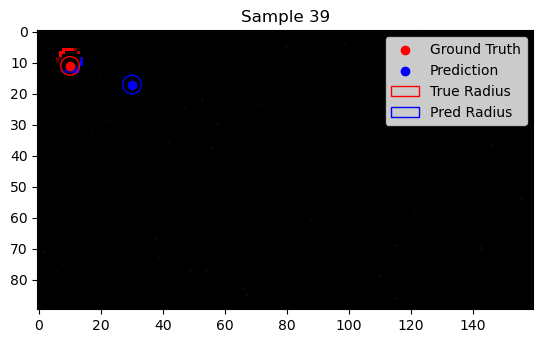

In [235]:
dt.show_next_img_w_pred(gen)

In [5]:
df = pd.read_csv('dataset_python_sim/positions_in_fov_0.5ms.csv')
df['y_cam'].max(), df['y_cam'].min()

(720.0, 1.0)

# Kalman Filter Integration

In [4]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'throws'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='train' size: 54
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='test' size: 13
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='val' size: 11


In [9]:
# Load model
model = network.load_model('models/VideoClassification_q8_10ts_50e.pt', network.SCNNVideoClassification, trainset_in, device)

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Evaluating video regression tracker
Error 0: μ=1.85, σ=2.33, 95% CI=5.672 pixels
Error 1: μ=1.91, σ=2.90, 95% CI=6.684 pixels
Error 2: μ=2.02, σ=3.94, 95% CI=8.504 pixels
Total errors: σ=4.50, 95% CI=11.016 pixels


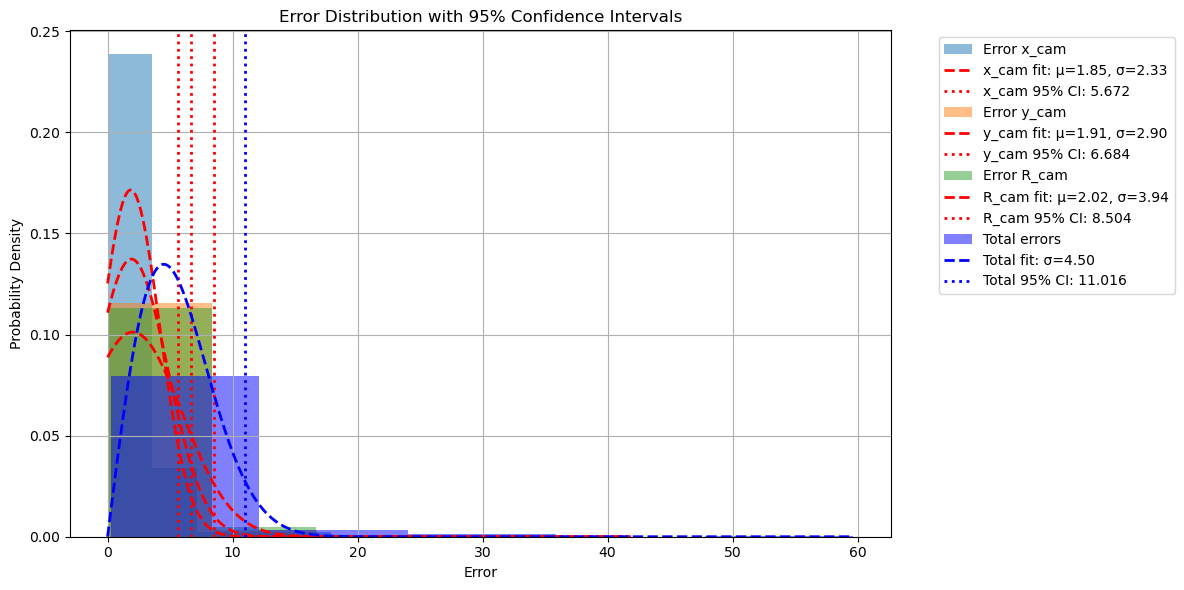

In [30]:
model.evaluate(valid_loader_in, device, num_steps=10, print_results=True, weighted_avg=True, operation = 'distribution')

Evaluating video classification tracker
Error 0: μ=2.28, σ=2.97, 95% CI=7.164 pixels
Error 1: μ=2.19, σ=3.16, 95% CI=7.385 pixels
Error 2: μ=2.04, σ=4.00, 95% CI=8.622 pixels
Total errors: σ=4.95, 95% CI=12.110 pixels


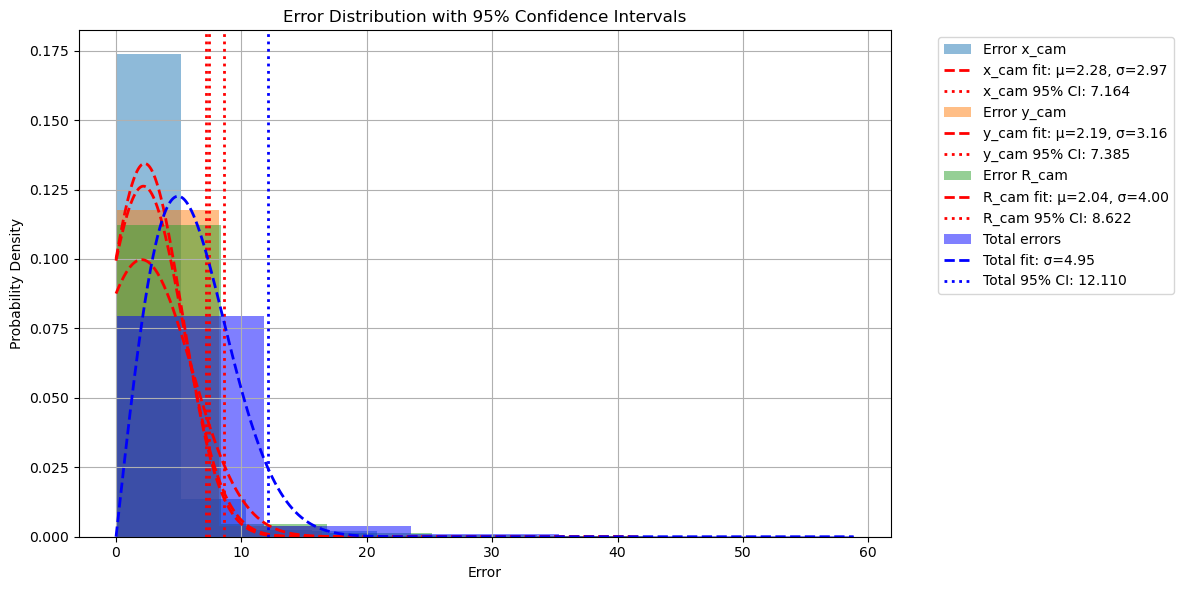

In [66]:
model.evaluate(valid_loader_in, device, num_steps=10, print_results=True, operation= 'distribution')

In [21]:
# Load video
idx = 0
dataset = trainset_in
video, labels, length = dataset.__getitem__(idx)
tr = dataset.__gettr__(idx)
labels = labels.transpose(0, 1)

In [ ]:
# Get predictions
preds = network.get_preds_video_regression(model, video, length, dataset.labels, device, num_steps=10, weighted_avg=True)

3
3
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
(3, 45)


In [53]:
from simulator import Camera, Field

# Convert to X,Y,Z  coordinates
W = 14.0      # field width (m)
L = 11.0       # field length (m)

field = Field(W, L, 2.4, 1)


# CameraLeft
cam_x = -0.05994 + 7
cam_y = -11 + 0.12 + 0.025 + 11
cam_z = 0.55

camera_pos = np.array([cam_x, cam_y, cam_z])          # Camera position in world space

fps = 200

# ---------------------
# Define camera parameters for the pinhole model
# ---------------------      
# Where the camera is looking (center of field)
camera_target = np.array([field.center[0], field.center[1], camera_pos[2]])        # Where the camera is looking (center of field) It would be good to transform this into an angle and assume verticality
orientation = Camera.get_orientation(camera_pos, camera_target)
img_width, img_height = 1280, 720               # Image resolution (in pixels)
focal_length = 0.008                             # Focal length in meters

CAMERA = Camera(camera_pos, orientation, focal_length, img_width, img_height, fps = fps)

pred_pos = CAMERA.project_ball_camera_to_world(preds*dataset.quantization, False)
truth_pos = CAMERA.project_ball_camera_to_world(labels*dataset.quantization, False)




In [60]:
from kalman import CA3DKalmanFilter

# Example usage:
delta_t = 0.01 # seconds
process_var_acc = 0.01
meas_var_pos = 0.5
initial_state = np.array([0,0,0, 0,0,0, 0,0,-9.81])

kf = CA3DKalmanFilter(delta_t, process_var_acc, meas_var_pos)

n_timesteps = len(pred_pos)
print(n_timesteps)
cutoff = 0.4 # seconds
last_measurement_ts = int(cutoff/delta_t)

positions = np.zeros((n_timesteps, 3))
print(positions.shape)
for i, z in enumerate(pred_pos):
    kf.predict()
    if i < last_measurement_ts: kf.update(z)
    positions[i] = kf.x.flatten()[:3]


print("Estimated state (pos,vel,acc):")
print(kf.x.flatten())
print(kf.x.flatten()[:3])



45
(45, 3)
Estimated state (pos,vel,acc):
[  5.17363169   5.32475221   1.64722454   2.08330883 -12.47546382
   1.39749054   8.88954048 -32.43170388  -8.92298762]
[5.17363169 5.32475221 1.64722454]


Text(0.5, 0, 'Z Position')

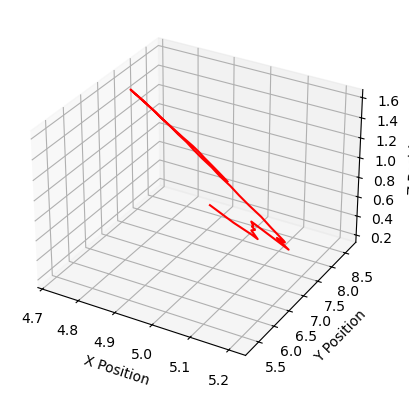

In [58]:
# Plot 3d positions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Kalman Filter', color='red')
# ax.plot(pred_pos[:last_measurement_ts, 0], pred_pos[:last_measurement_ts, 1], pred_pos[:last_measurement_ts, 2], label='Measurements', color='blue')
# ax.plot(truth_pos[:, 0], truth_pos[:, 1], truth_pos[:, 2], label='Ground Truth', color='green')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

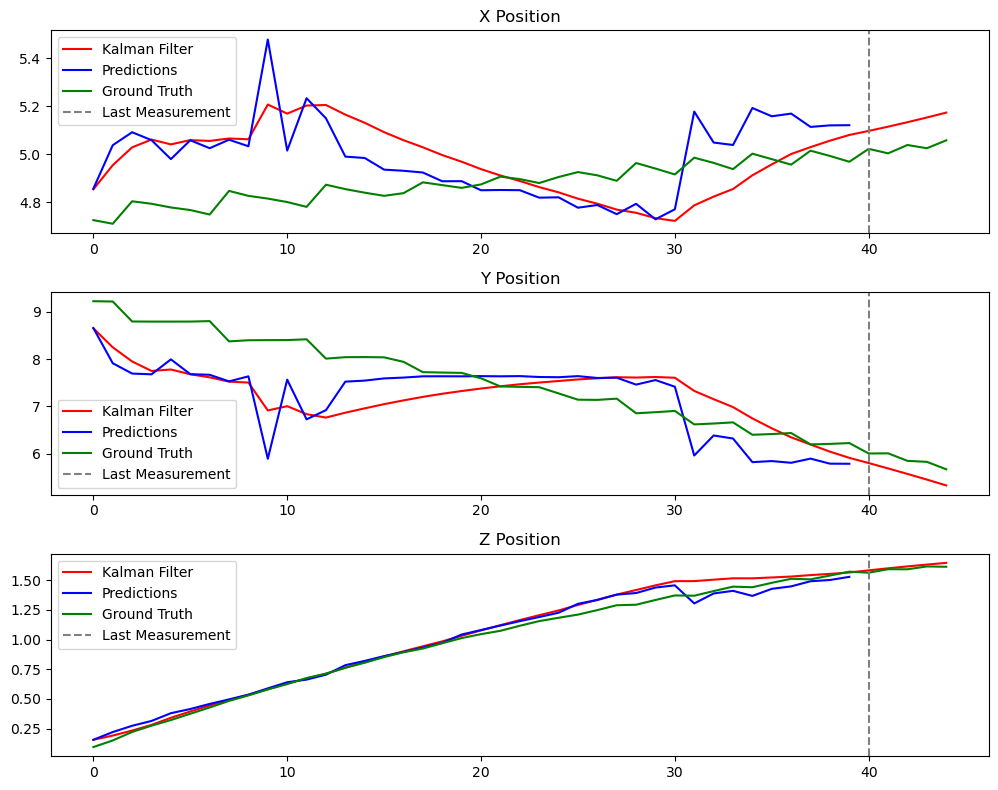

In [59]:
# Plot separate coordinate positions
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
for i, label in enumerate(['X', 'Y', 'Z']):
    axs[i].plot(positions[:, i], label='Kalman Filter', color='red')
    axs[i].plot(pred_pos[:last_measurement_ts, i], label='Predictions', color='blue')
    axs[i].plot(truth_pos[:, i], label='Ground Truth', color='green')
    axs[i].axvline(x=last_measurement_ts, color='grey', linestyle='--', label='Last Measurement')
    axs[i].set_title(f'{label} Position')
    axs[i].legend()
plt.tight_layout()
plt.show()

In [54]:
df = pd.DataFrame(labels.transpose(0,1).numpy()*dataset.quantization, columns=['x_cam', 'y_cam', 'R_cam'])
# apply function to each row
df[['x', 'y', 'z']] = df[['x_cam', 'y_cam', 'R_cam']].apply(CAMERA.project_ball_camera_to_world, axis=1, result_type='expand')

In [55]:
csv_file = os.path.join(dataset_path, 'positions_10ms.csv')
ground_truth = pd.read_csv(csv_file)


In [56]:
df[['gt_x', 'gt_y', 'gt_z']] = ground_truth[ground_truth['tr'] == tr][['x', 'y', 'z']].iloc[:len(df)].values
df

,x_cam,y_cam,R_cam,x,y,z,gt_x,gt_y,gt_z
0,219.000000,277.000000,20.000000,4.726037,9.223847,0.093500,4.808081,8.888889,0.110000
1,215.981049,287.102051,20.014286,4.711026,9.217553,0.149347,4.813976,8.815241,0.165682
2,213.957413,297.204620,20.993671,4.804411,8.794423,0.220973,4.819870,8.741594,0.220360
3,211.896088,307.317505,20.999338,4.794190,8.792210,0.274035,4.825765,8.667946,0.274033
4,208.931442,316.363464,20.999859,4.778715,8.792170,0.321426,4.831660,8.594299,0.326702
5,206.918518,326.505951,20.998566,4.768038,8.792820,0.374543,4.837555,8.520651,0.378366
6,203.809052,336.605408,20.975639,4.749359,8.802455,0.427315,4.843450,8.447004,0.429025
7,201.740768,346.603577,22.069510,4.847632,8.373465,0.483229,4.849345,8.373356,0.478680
8,198.847961,355.839172,22.005463,4.827083,8.397576,0.529201,4.855240,8.299709,0.527330
9,196.671860,365.958405,22.000227,4.815700,8.399662,0.579792,4.861134,8.226061,0.574976
